In [222]:
%load_ext autoreload
%autoreload 2

import os, torch, click, numpy as np

import swyft
from utils import *
from plot import *

from tqdm import tqdm



DEVICE = 'cuda'


from torch import tensor

imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5), origin='lower') #left, right, bottom, top

import matplotlib.colors
from IPython.display import HTML
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams.update({'font.size': 15})



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
m = 2
nsub = 1
nsim = 50_000
nmbins = 1

sigma = 0.
lr = 1e-3
factor = 1e-1
patience = 5

system_name = "ngc4414"

In [98]:
def noise(obs, _= None, sigma_n = sigma):
        image = obs["image"]
        eps = np.random.randn(*image.shape) * sigma_n
        return {"image": image + eps}

# Set utilities
sim_name, sim_path = get_sim_path(m, nsub, nsim, system_name)
store = swyft.Store.load(path=sim_path)
print(f'Store has {len(store)} simulations.')

config = get_config(system_name, str(nsub), str(m))

prior, n_pars, lows, highs = get_prior(config)
L = config.kwargs["defs"]["nx"]
print(f'Image has L = {L}.')

dataset_name, dataset_path = get_dataset_path(m, nsub, nsim, system_name, sigma)
dataset = swyft.Dataset.load(filename=dataset_path, store=store, simhook = noise)

Store _M_m2_nsub1_nsim50000 exists!
Loading existing store.
Store has 50050 simulations.
Image has L = 40.
Dataset _M_m2_nsub1_nsim50000_sigma0.0 exists!


In [99]:
# Load network
mre_name, mre_path = get_mre_path(sim_name, nmbins, sigma, lr, factor, patience)
print(f'Loading {mre_name}!')

torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK

marginal_indices, _ = swyft.utils.get_corner_marginal_indices(n_pars)

network = get_custom_marginal_classifier(
    observation_transform = CustomObservationTransform('image', {'image': (L, L)}),
    marginal_indices = marginal_indices,
    L = L,
    nmbins = nmbins, 
    lows = lows,
    highs = highs,
    marginal_classifier = CustomMarginalClassifier,
)

mre = swyft.MarginalRatioEstimator.load(
    network=network,
    device=DEVICE,
    filename=mre_path,
)

torch.set_default_tensor_type(torch.FloatTensor)

Loading UNet_M_m2_nsub1_nsim50000_nmbins1_sigma0.0_lr-3.0_fac-1.0_pat5.pt!


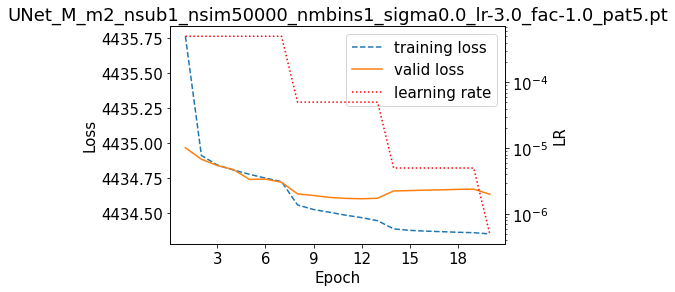

In [100]:
plot_losses(mre, title = mre_name)#, save_name = mre_name);

In [174]:
def get_empty_and_full_coords(nmbins, L):
    grid = torch.linspace(lows[0], highs[0], L+1)[:-1]
    x, y = torch.meshgrid(grid, grid, indexing = 'xy')
    m = torch.logspace(lows[-1], highs[-1], 2*nmbins+1)
    m_centers, m_edges = m[1::2], m[0::2]
    ms = [torch.full((L*L,), m_i) for m_i in m_centers]

    coord_empty = torch.tensor((), device = DEVICE, dtype = torch.float).reshape(1, -1)
    coord_full = torch.cat( [torch.transpose(torch.stack((x.flatten(), y.flatten(), m)), 0, 1) for m in ms] ).reshape(1, -1).to(DEVICE, dtype = torch.float)

    return coord_empty, coord_full, m_centers, m_edges 

def get_obs(dataset, i = -1):
    obs0_i = np.random.randint(0, len(dataset)) if i == -1 else i
    
    obs0 = dataset[obs0_i][0]
    v0 = dataset[obs0_i][2]

    obs0['image'] = obs0['image'].unsqueeze(0).to(DEVICE, dtype = torch.float)
    v0 = v0.unsqueeze(0).to(DEVICE)
    
    return obs0, v0, obs0_i

coord_empty, coord_full, m_centers, m_edges = get_empty_and_full_coords(nmbins, L)

mbins = np.linspace(lows[2], highs[2], nmbins + 1)
title_mbins = [f'mass {mbins[i]} - {mbins[i+1]}' for i in range(nmbins)]
title_halos = [f'{j} {k}' for j in ['no halo', 'halo'] for k in title_mbins ]
titles = [f'{i} {j}' for i in ['target', 'ratio '] for j in title_halos ]

get_obs(dataset);

In [141]:
prior = nsub/(L*L)/nmbins
prior0 = 1 - prior
prior1 = prior
priors = np.repeat(np.array([prior0, prior1]), nmbins) 

print(f'prior no halo \t{prior0}\nprior halo \t{prior1}')

prior no halo 	0.999375
prior halo 	0.000625


In [212]:
def get_pred(obs0_i = -1):
    
    # Get observation and targets
    obs0, v0, obs0_i = get_obs(dataset, obs0_i)
    targets = mre.network.parameter_transform(v0).squeeze()
    target = targets[nmbins:].numpy()

    # Get logratios
    logratios = np.zeros((nmbins*2, L, L))
    logratios[:nmbins] = mre.network(obs0, coord_empty).view(nmbins*2, L, L)[:nmbins]
    logratios[nmbins:] = mre.network(obs0, coord_full).view(nmbins*2, L, L)[nmbins:]
        
    # Posterior 
    posts = np.exp(logratios) * (priors)[:, np.newaxis, np.newaxis]
    posts_sum = np.sum(posts.reshape(2, nmbins, L, L).transpose([1,0,2,3]), axis = 1)
    posts_sum = np.tile(posts_sum, (2,1,1))
    posts_norm = posts / posts_sum
    post = posts_norm[nmbins:]
    
    obs0 = obs0['image'].squeeze().numpy()
    v0 = v0.numpy()
    
        
    return post, target, obs0, v0, obs0_i

post, target, obs0, v0, obs0_i = get_pred();
# post.shape, target.shape, obs0.shape, v0.shape

In [190]:
def get_target_coords(v0, target):
    x, y, m = v0.view(-1, 3).T.numpy()
    m_i = np.where(target == 1)[0]
    return np.array((m_i, y, x)).T


for _ in range(4):
    post, target, obs0, v0, obs0_i = get_pred()
    
    
    nrows = find_nrows(len(post))
    titles = [rf'$M_{{sub}} = 10^{ {m} }\ M_{{\odot}}$' for m in np.log10(m_centers.numpy())]

    log = True
#     plt_imshow(post, nrows, target_coords = get_target_coords(v0, target), cbar = True, titles = titles, tl = True, ylog = log, **imkwargs)
#     plt_imshow(post, nrows, target_coords = target_coords_alt, cbar = True, titles = titles, tl = True, ylog = log, **imkwargs)


In [219]:
npred = 10 #len(dataset)
pred = {
    'post':   np.zeros((npred, *post.shape)),
    'target': np.zeros((npred, *target.shape)),
    'obs0':   np.zeros((npred, *obs0.shape)),
    'v0':     np.zeros((npred, *v0.shape)),
    'obs0_i': np.zeros((npred)),
}

In [220]:
for i in tqdm(range(npred)): # loop over number of observations we will take into account
    post, target, obs0, v0, obs0_i = get_pred()
    for name, var in zip(pred.keys(), get_pred()):
        pred[name][i] = var
    

100%|██████████| 10/10 [00:00<00:00, 20.27it/s]


In [226]:
def get_pred_path(mre_name, npred, save_dir = '../data/pred'):
    pred_name = f'{mre_name[:-3]}_npred{npred}.npy'
    pred_path = os.path.join(save_dir, pred_name)
    return pred_name, pred_path

In [227]:
get_pred_path(mre_name, npred)

('UNet_M_m2_nsub1_nsim50000_nmbins1_sigma0.0_lr-3.0_fac-1.0_pat5_npred10.npy',
 '../data/pred/UNet_M_m2_nsub1_nsim50000_nmbins1_sigma0.0_lr-3.0_fac-1.0_pat5_npred10.npy')

In [30]:
OVERWRITE = False
preds_name = f'../data/preds/{mre_name[:-3]}_nobs{n_obs}_PREDS.npy'

if OVERWRITE is True or not os.path.exists(preds_name):
    for i in tqdm(range(n_obs)): # loop over number of observations we will take into account
        post, target_coords, target_coords_alt, scatter, scatter_alt, obs0_i, obs0, [x,y,m], posts_all, target, obs0_i = get_pred()
        posts[i], targets[i] = post, target
        inds[i] = obs0_i
        obs0s[i] = obs0['image'].squeeze().numpy()

    with open(preds_name, 'wb') as f:
        np.save(f, posts)
        np.save(f, targets)
        np.save(f, inds)
        np.save(f, obs0s)

else:
    print(f'Already saved, only loading {preds_name}')
    with open(preds_name, 'rb') as f:
        posts   = np.load(f)
        targets = np.load(f)
        inds    = np.load(f)
        obs0s   = np.load(f)

100%|██████████| 10000/10000 [04:56<00:00, 33.78it/s]


In [33]:
def get_f(posts, targets, x):
    
    x1, x2 = x[:-1], x[1:]
    
    def f3(xi, xj):
        y = targets[(posts > xi) & (posts < xj)]
        return y.sum() / len(y) if y.sum() != 0 else 0

    return np.array([f3(xi, xj) for xi, xj in zip(x1, x2)])

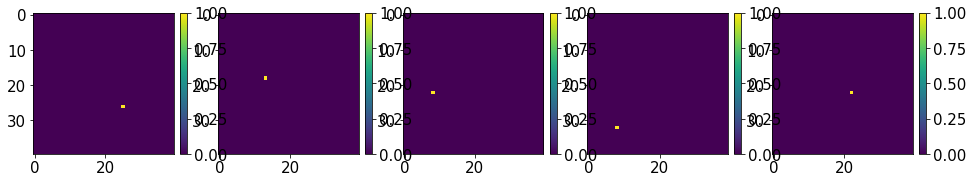

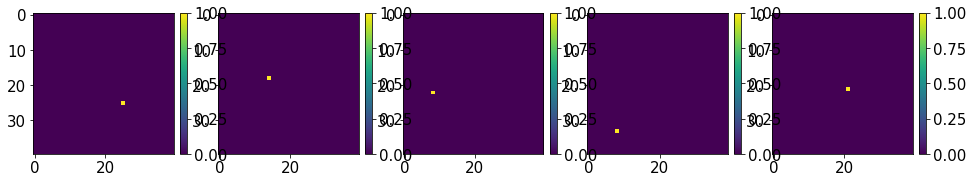

In [50]:
plt_imshow(.squeeze()[:5], cbar = True)
plt_imshow(targets.squeeze()[:5], cbar = True)

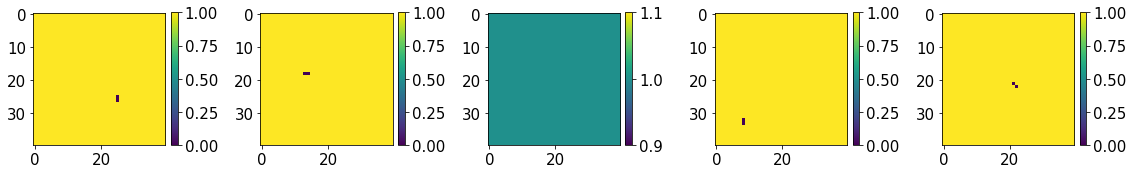

In [59]:
plt_imshow((np.round(posts) == targets).squeeze()[:5], cbar = True, tl = True)

TypeError: Invalid shape (5, 40, 40) for image data

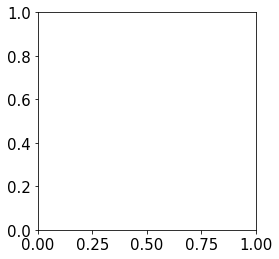

In [52]:
plt.imshow((np.round(posts) == targets).squeeze()[:5])

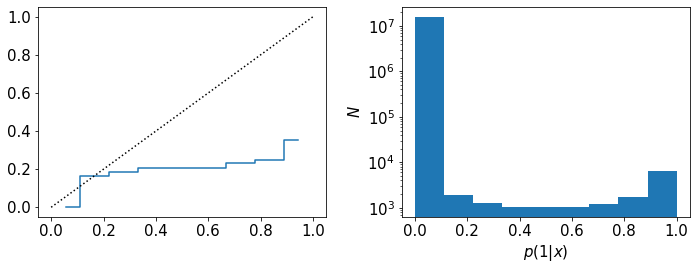

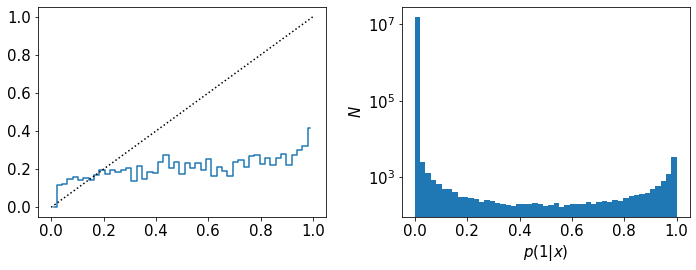

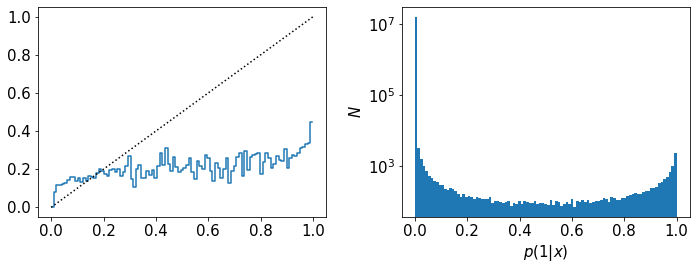

In [42]:
for i in [10, 50, 100]:
    alpha_edges = np.linspace(0, 1, i)
    alpha_centers = (alpha_edges[:-1] + alpha_edges[1:])/2

    f = get_f(posts, targets, alpha_edges)

    fig, (axs0, axs1) = plt.subplots(1, 2, figsize = (10, 4), tight_layout = True)

    ax = axs0
    ax.step(alpha_centers, f, where='mid')
    ax.plot([0, 1], [0, 1], "k:")

    ax = axs1
    ax.hist(posts.flatten(), bins = alpha_edges)
    ax.set_yscale('log')
    ax.set_xlabel(r'$p(1|x)$')
    ax.set_ylabel(r'$N$')

    plt.show()

